In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import os
import face_recognition

%matplotlib inline

In [2]:
files_paths = glob.glob('emoji_challenge/*/*.jpg')
print(f'Total: {len(files_paths)}')
files_paths = [file for file in files_paths if 'problematic' not in file]
print(f'Excluding problematic: {len(files_paths)}')

Total: 1139
Excluding problematic: 1139


In [23]:
for folder in os.listdir('emoji_challenge'):
    if os.path.isdir(os.path.join('emoji_challenge', folder)):
        print(f'{folder}: {len(os.listdir(os.path.join("emoji_challenge", folder)))}')

eye_roll: 14580
sad: 2691
kiss: 36356
very_sad_problematic: 228
cringe: 11988
surprise: 17031
angry: 38750
surprise_problematic: 176
kiss_problematic: 487
here_we_go: 21906
clenched_teeth_problematic: 83
disgust_problematic: 194
sad_problematic: 20
angry_problematic: 396
very_sad: 21670
eye_roll_problematic: 151
clenched_teeth: 9732
cringe_problematic: 115
disgust: 24357


## Cropping and padding

emoji_challenge/angry_subset/6659405379006369029_frame_16.jpg


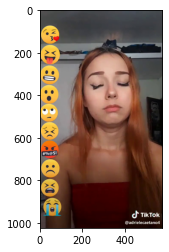

In [8]:
random_idx = 0
print(files_paths[random_idx])
image = cv2.imread(files_paths[random_idx])[...,::-1]
plt.imshow(image)

In [9]:
# This function crops the image to be square with its dimensions min(height, width) x min(height, width)
def crop_img(img): 
    center = (img.shape[0]//2, img.shape[1]//2)
    half_len = min(center[0], center[1])
    img = img[center[0]-half_len:center[0]+half_len, center[1]-half_len:center[1]+half_len]
    return img

In [10]:
# This function zero-pads the image on the top+bottom/left+right so that it's a square
def zero_pad_img(img):
    height, width, channels = img.shape
    if width > height:
        pad_amt = (width - height) // 2
        img = cv2.copyMakeBorder(img, pad_amt, pad_amt, 0, 0, cv2.BORDER_CONSTANT, value=0)
    else:
        pad_amt = (height - width) // 2
        img = cv2.copyMakeBorder(img, 0, 0, pad_amt, pad_amt, cv2.BORDER_CONSTANT, value=0)
    return img

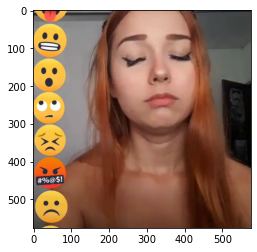

In [11]:
crop_image = crop_img(image)
plt.imshow(crop_image)

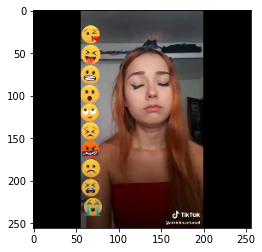

In [14]:
pad_image = zero_pad_img(image)
pad_image = cv2.resize(pad_image, (256, 256))
plt.imshow(pad_image)

In [33]:
%%time
if not os.path.exists('resized_emoji_challenge'):
    os.makedirs('resized_emoji_challenge')
for file in files_paths:
    relative_path = os.path.join(*(file.split(os.path.sep)[1:]))
    folder, filename = os.path.split(relative_path)
    if not os.path.exists(os.path.join('resized_emoji_challenge', folder)):
        os.makedirs(os.path.join('resized_emoji_challenge', folder))
    image = cv2.imread(file)
    image = zero_pad_img(image)
    image = cv2.resize(image, (256, 256))
    cv2.imwrite(os.path.join('resized_emoji_challenge/', folder, filename), image)

CPU times: user 34min 24s, sys: 3min 26s, total: 37min 51s
Wall time: 41min 51s


## Remove sketched emojies
Many of the images are in the shape of a square and have a picture of a person on the left and a picture of a hand-drawn emoji on the right. We don't care about the emoji on the right, so we want to remove it. 

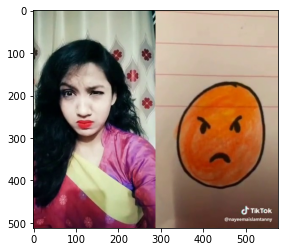

In [33]:
sketch_image_file = 'emoji_challenge/angry_subset/6614506069496433926_frame_14.jpg'
sketch_image = cv2.imread(sketch_image_file)[...,::-1]
plt.imshow(sketch_image)

In [25]:
# Returns the proportion of an image's height to its width
def dimension_prop(img): 
    height, width, n_channels = img.shape
    return height / width

In [26]:
# Returns original image if original image is tall, otherwise cuts it in half widthwise
def tall_image(img): 
    img_prop = dimension_prop(img)
    if img_prop < 1.25: # arbitrary boundary, we can try other stuff too
        width = img.shape[1] // 2
        return img[:, :width, :]
    else: 
        return img

In [24]:
print(f'Image: {dimension_prop(image)}')
print(f'Sketch image: {dimension_prop(sketch_image)}')

Image: 1.7777777777777777
Sketch image: 0.8888888888888888


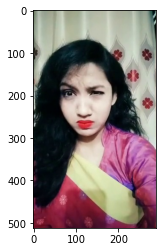

In [27]:
sketch_image_tall = tall_image(cv2.imread(sketch_image_file))[...,::-1]
plt.imshow(sketch_image_tall)

In [36]:
%%time
if not os.path.exists('resized_emoji_challenge'):
    os.makedirs('resized_emoji_challenge')
for file in files_paths:
    relative_path = os.path.join(*(file.split(os.path.sep)[1:]))
    folder, filename = os.path.split(relative_path)
    if not os.path.exists(os.path.join('resized_emoji_challenge', folder)):
        os.makedirs(os.path.join('resized_emoji_challenge', folder))
    image = cv2.imread(file)
    image = tall_image(image)
    if not len(face_recognition.face_locations(image)): 
        continue
    image = zero_pad_img(image)
    image = cv2.resize(image, (256, 256))
    cv2.imwrite(os.path.join('resized_emoji_challenge/', folder, filename), image)

emoji_challenge/angry_subset/6659405379006369029_frame_16.jpg
emoji_challenge/angry_subset/6665956956433304833_frame_5.jpg
emoji_challenge/angry_subset/6652708869992615174_frame_12.jpg
emoji_challenge/angry_subset/6761379843545353474_frame_8.jpg
emoji_challenge/angry_subset/6625794747216694534_frame_4.jpg
emoji_challenge/angry_subset/6616635902728867078_frame_5.jpg
emoji_challenge/angry_subset/6670696821448264962_frame_14.jpg
emoji_challenge/angry_subset/6665297797115284742_frame_14.jpg
emoji_challenge/angry_subset/6653079369126251781_frame_1.jpg
emoji_challenge/angry_subset/6616345605943872774_frame_12.jpg
emoji_challenge/angry_subset/6655218178714635521_frame_15.jpg
emoji_challenge/angry_subset/6616291772140096773_frame_8.jpg
emoji_challenge/angry_subset/6670824463862385922_frame_3.jpg
emoji_challenge/angry_subset/6616598427641842950_frame_15.jpg
emoji_challenge/angry_subset/6659286988191026434_frame_16.jpg
emoji_challenge/angry_subset/6654945525940358406_frame_16.jpg
emoji_challenge

emoji_challenge/angry_subset/6653419148275617030_frame_5.jpg
emoji_challenge/angry_subset/6616400781518048517_frame_1.jpg
emoji_challenge/angry_subset/6653045323159571717_frame_16.jpg
emoji_challenge/angry_subset/6679055928005758214_frame_14.jpg
emoji_challenge/angry_subset/6658968858033917190_frame_8.jpg
emoji_challenge/angry_subset/6615592291291630853_frame_6.jpg
emoji_challenge/angry_subset/6654915278977109253_frame_7.jpg
emoji_challenge/angry_subset/6658604214958165254_frame_11.jpg
emoji_challenge/angry_subset/6773306013383773446_frame_4.jpg
emoji_challenge/angry_subset/6676701341227683078_frame_2.jpg
emoji_challenge/angry_subset/6655567906786512134_frame_13.jpg
emoji_challenge/angry_subset/6673763011120860422_frame_10.jpg
emoji_challenge/angry_subset/6657104266559229190_frame_6.jpg
emoji_challenge/angry_subset/6672410814726540549_frame_10.jpg
emoji_challenge/angry_subset/6676711448032447746_frame_4.jpg
emoji_challenge/angry_subset/6672395923831655686_frame_6.jpg
emoji_challenge/an

emoji_challenge/angry_subset/6654101942031092997_frame_11.jpg
emoji_challenge/angry_subset/6668905564027751685_frame_14.jpg
emoji_challenge/angry_subset/6634862211632205062_frame_5.jpg
emoji_challenge/angry_subset/6618393492978666758_frame_6.jpg
emoji_challenge/angry_subset/6653742784110923013_frame_5.jpg
emoji_challenge/angry_subset/6700158433921862917_frame_9.jpg
emoji_challenge/angry_subset/6654567648359091462_frame_8.jpg
emoji_challenge/angry_subset/6662202598315035905_frame_5.jpg
emoji_challenge/angry_subset/6656132838997363973_frame_1.jpg
emoji_challenge/angry_subset/6617310965950057734_frame_14.jpg
emoji_challenge/angry_subset/6614506069496433926_frame_10.jpg
emoji_challenge/angry_subset/6710250082295368966_frame_9.jpg
emoji_challenge/angry_subset/6655577432306896130_frame_12.jpg
emoji_challenge/angry_subset/6662352665340546309_frame_16.jpg
emoji_challenge/angry_subset/6655329386167799045_frame_11.jpg
emoji_challenge/angry_subset/6657762577113697541_frame_12.jpg
emoji_challenge/

emoji_challenge/angry_subset/6660940235456646406_frame_6.jpg
emoji_challenge/angry_subset/6659284638608952578_frame_5.jpg
emoji_challenge/angry_subset/6798514019822062853_frame_16.jpg
emoji_challenge/angry_subset/6653878301418851590_frame_5.jpg
emoji_challenge/angry_subset/6615457374826138886_frame_3.jpg
emoji_challenge/angry_subset/6656808947187453190_frame_13.jpg
emoji_challenge/angry_subset/6654688590607420677_frame_2.jpg
emoji_challenge/angry_subset/6655665395053104390_frame_12.jpg
emoji_challenge/angry_subset/6657170505650408709_frame_13.jpg
emoji_challenge/angry_subset/6657841731158936837_frame_14.jpg
emoji_challenge/angry_subset/6654848233484913922_frame_5.jpg
emoji_challenge/angry_subset/6652949146133073157_frame_5.jpg
emoji_challenge/angry_subset/6684254941059484933_frame_8.jpg
emoji_challenge/angry_subset/6656333610712304902_frame_2.jpg
emoji_challenge/angry_subset/6666609824714853633_frame_14.jpg
emoji_challenge/angry_subset/6675716039877070086_frame_6.jpg
emoji_challenge/an

emoji_challenge/angry_subset/6670824463862385922_frame_7.jpg
emoji_challenge/angry_subset/6808468524311383301_frame_2.jpg
emoji_challenge/angry_subset/6655921194316877062_frame_9.jpg
emoji_challenge/angry_subset/6693628295470124290_frame_4.jpg
emoji_challenge/angry_subset/6657438715415104774_frame_4.jpg
emoji_challenge/angry_subset/6657908615220825350_frame_10.jpg
emoji_challenge/angry_subset/6658971897096572166_frame_2.jpg
emoji_challenge/angry_subset/6657409414640700678_frame_2.jpg
emoji_challenge/angry_subset/6672434199418375430_frame_14.jpg
emoji_challenge/angry_subset/6661505287045778693_frame_1.jpg
emoji_challenge/angry_subset/6656593035146562821_frame_3.jpg
emoji_challenge/angry_subset/6661606046269721861_frame_11.jpg
emoji_challenge/angry_subset/6662276985319853318_frame_7.jpg
emoji_challenge/angry_subset/6650514005456588038_frame_9.jpg
emoji_challenge/angry_subset/6655643233630031110_frame_15.jpg
emoji_challenge/angry_subset/6615181992545750278_frame_2.jpg
emoji_challenge/angr

emoji_challenge/angry_subset/6690886633224424710_frame_9.jpg
emoji_challenge/angry_subset/6662202598315035905_frame_8.jpg
emoji_challenge/angry_subset/6797472064342134022_frame_9.jpg
emoji_challenge/angry_subset/6655879935342677253_frame_9.jpg
emoji_challenge/angry_subset/6797033563406470405_frame_4.jpg
emoji_challenge/angry_subset/6662202598315035905_frame_1.jpg
emoji_challenge/angry_subset/6653433507412446470_frame_14.jpg
emoji_challenge/angry_subset/6798036254714809605_frame_12.jpg
emoji_challenge/angry_subset/6719798009577688322_frame_9.jpg
emoji_challenge/angry_subset/6762268869139647749_frame_7.jpg
emoji_challenge/angry_subset/6653103789811174662_frame_6.jpg
emoji_challenge/angry_subset/6655936289679871238_frame_13.jpg
emoji_challenge/angry_subset/6652703724768611589_frame_13.jpg
emoji_challenge/angry_subset/6656652534280621318_frame_11.jpg
emoji_challenge/angry_subset/6654560759911025926_frame_2.jpg
emoji_challenge/angry_subset/6665015546263637253_frame_7.jpg
emoji_challenge/ang

emoji_challenge/angry_subset/6671490339297037574_frame_16.jpg
emoji_challenge/angry_subset/6657366513030335746_frame_11.jpg
emoji_challenge/angry_subset/6665297797115284742_frame_1.jpg
emoji_challenge/angry_subset/6656163666926243077_frame_14.jpg
emoji_challenge/angry_subset/6676711448032447746_frame_1.jpg
emoji_challenge/angry_subset/6666341216004607237_frame_15.jpg
emoji_challenge/angry_subset/6657438715415104774_frame_7.jpg
emoji_challenge/angry_subset/6663614573871893766_frame_4.jpg
emoji_challenge/angry_subset/6656699412128992517_frame_1.jpg
emoji_challenge/angry_subset/6654969534555884805_frame_15.jpg
emoji_challenge/angry_subset/6658532645275716870_frame_11.jpg
emoji_challenge/angry_subset/6672362507912367366_frame_5.jpg
emoji_challenge/angry_subset/6626899627545218310_frame_3.jpg
emoji_challenge/angry_subset/6654101942031092997_frame_2.jpg
emoji_challenge/angry_subset/6659037703004228869_frame_8.jpg
emoji_challenge/angry_subset/6703214031794081030_frame_2.jpg
emoji_challenge/an

emoji_challenge/angry_subset/6615066009831214342_frame_16.jpg
emoji_challenge/angry_subset/6657834709743045893_frame_6.jpg
emoji_challenge/angry_subset/6669685136923184386_frame_3.jpg
emoji_challenge/angry_subset/6666381814057143557_frame_9.jpg
emoji_challenge/angry_subset/6659477316537683205_frame_14.jpg
emoji_challenge/angry_subset/6654394653330115846_frame_5.jpg
emoji_challenge/angry_subset/6652932866558659846_frame_1.jpg
emoji_challenge/angry_subset/6822512991322393857_frame_8.jpg
emoji_challenge/angry_subset/6678254873437277445_frame_5.jpg
emoji_challenge/angry_subset/6615878708542573829_frame_15.jpg
emoji_challenge/angry_subset/6614752182963014917_frame_13.jpg
emoji_challenge/angry_subset/6657527316249316614_frame_8.jpg
emoji_challenge/angry_subset/6666243776840731909_frame_3.jpg
emoji_challenge/angry_subset/6652960082868833542_frame_3.jpg
emoji_challenge/angry_subset/6670696821448264962_frame_11.jpg
emoji_challenge/angry_subset/6663964527958248705_frame_4.jpg
emoji_challenge/ang

emoji_challenge/angry_subset/6654210901115145478_frame_12.jpg
emoji_challenge/angry_subset/6798514019822062853_frame_8.jpg
emoji_challenge/angry_subset/6668200829880634629_frame_7.jpg
emoji_challenge/angry_subset/6673435616925011201_frame_4.jpg
emoji_challenge/angry_subset/6659746024287898885_frame_6.jpg
emoji_challenge/angry_subset/6658686766167362822_frame_6.jpg
emoji_challenge/angry_subset/6654810751166844165_frame_16.jpg
emoji_challenge/angry_subset/6668837093663313158_frame_14.jpg
emoji_challenge/angry_subset/6660379438141672706_frame_10.jpg
emoji_challenge/angry_subset/6666700111155825926_frame_12.jpg
emoji_challenge/angry_subset/6654901673950973189_frame_16.jpg
emoji_challenge/angry_subset/6657318659825863942_frame_7.jpg
emoji_challenge/angry_subset/6657833253161929989_frame_10.jpg
emoji_challenge/angry_subset/6654543614095396101_frame_4.jpg
emoji_challenge/angry_subset/6661025033051180293_frame_4.jpg
emoji_challenge/angry_subset/6653538459501726982_frame_10.jpg
emoji_challenge/

# Try out RetinaFace face detector


In [34]:
face_locations = face_recognition.face_locations(sketch_image)
print(face_locations)

[(168, 182, 297, 53)]
